### Validating analytic workflows

In this notebook we will show how to use simulations and create synthetic data to validate an analysis workflow.



In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import scoreatpercentile
from factor_analyzer import FactorAnalyzer
from sdv.constraints import Positive
from sdv.lite import TabularPreset
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.metrics import balanced_accuracy_score, r2_score
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from nilearn.maskers import NiftiMasker
from nilearn.image import smooth_img, index_img

### Generating synthetic data de novo for initial analysis development

We will first generate synthetic data for an analysis that compares behavior on broad set of surveys related to impulsivity with the likelihood of having ever been arrested in one's life (based on [Eisenberg et al., 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6534563/)). 

There are four impulsuvity measures of interest, some of which have multiple subscales; the names of the variables for each subscale are listed in parentheses:

- The Barratt Impulsiveness Scale, Version 11 ("BIS11"), which includes subscales for Motor (`BIS11.Motor`), Nonplanning (`BIS11.Nonplanning`), and Attentional impulsivity (`BIS11.Attentional`).
- The UPPS-P Impulsive Behavior Scale ("UPPS"), where "UPPS-P" refers to different subscales of impulsivity: (Negative) Urgency (`UPPS.negative_urgency`), Premeditation (lack of) (`UPPS.lack_of_premeditation`), Perseverance (lack of) (`UPPS.lack_of_perseverance`), Sensation Seeking (`UPPS.sensation_seeking`), and Positive Urgency (`UPPS.positive_urgency`).
- The Dickman Impulsivity Inventory ("Dickman"), which includes subscales for functional (`Dickman.functional`) and dysfunctional (`Dickman.dysfunctional`) impulsivity.
- The Sensation Seeking Scale ("SSS"), which measures various aspects of disinhibition  (`SSS.disinhibition`), the tendency to seek thrills  (`SSS.thrill_adventure_seeking`) or novel experiences (`SSS.experience_seeking`), and the tendency towards boredom (`SSS.boredom_susceptibility`).

The study also included a demographic survey that included the following question: "How many times in your life have you been arrested and/or charged with illegal activities?"; because the distribution of this variable is highly skewed, we instead work with a summary variable (`everArrested`) that is a Boolean variable denoting whether or not the person has ever been arrested.  We also recorded the relevant demographic variables of `Age` and `Gender`.

We will start by creating completely synthetic data for these variables, as we might if we were creating our analysis code from scratch prior to data collection.  In this case the data are not meant to exactly mimic the distributions and ranges of the individual variables, but are intended to generate an expected overall structure.

For the impulsivity variables, we will generate them using a two-factor structure, where the factors correspond to impulsivity and sensation seeking; each variable is generated from those factors along with Gaussian noise.  We then use factor analyis to obtain the underlying factor scores, and then generate the `everArrested` variable to have some known relationship to those factors (either positive, or null), which we can use to test our analysis code.


In [14]:
def generate_synthetic_data(nsubs=500, noise_sd=1, latent_cor=0.2, arrest_noise_sd=1, 
                            p_arrest=0.20, betas=None, seed=None):
    if betas is None:
        betas = np.array([0.0, 0.5, .2, .5])


    impulsivity_vars = [
        'BIS11.Attentional',
        'BIS11.Motor',
        'BIS11.Nonplanning',
        'Dickman.dysfunctional',
        'UPPS.lack_of_perseverance',
        'UPPS.lack_of_premeditation',
        'UPPS.negative_urgency',
        'UPPS.positive_urgency',  
        'Dickman.functional',
        'SSS.boredom_susceptibility',
        'SSS.disinhibition',
        'SSS.experience_seeking',
        'SSS.thrill_adventure_seeking',
        'UPPS.sensation_seeking'
    ]

    factor_mtx = pd.DataFrame({
        'impulsivity': np.zeros(len(impulsivity_vars)),
        'senseek': np.zeros(len(impulsivity_vars))
    })
    factor_mtx['impulsivity'][:8] = 1
    factor_mtx['senseek'][8:] = 1

    rng = np.random.default_rng(seed)

    latent_vars = rng.multivariate_normal([0, 0], np.array([[1, latent_cor], [latent_cor, 1]]), size=nsubs)

    test_scores = latent_vars.dot(factor_mtx.T) + rng.normal(scale=noise_sd, size=(nsubs, factor_mtx.shape[0]))
    simdata_df = pd.DataFrame(test_scores, columns=impulsivity_vars)
    simdata_df['latent_impulsivity'] = latent_vars[:, 0]
    simdata_df['latent_senseek'] = latent_vars[:, 1]
    simdata_df['Age'] = rng.normal(loc=30, scale=5, size=nsubs)
    simdata_df['Sex'] = (rng.uniform(size=nsubs) > 0.5).astype('int')

    # generate arrest variable
    # first generate a continuous predictor, and then map to binary response
    arrest_predictor = simdata_df[['latent_impulsivity', 'latent_senseek', 'Age', 'Sex']].values.dot(betas) + rng.normal(scale=arrest_noise_sd, size=nsubs)
    simdata_df['everArrested'] = (arrest_predictor > scoreatpercentile(arrest_predictor, p_arrest * 100)).astype('int')

    fa = FactorAnalyzer(2, rotation='oblimin')
    fa_scores = fa.fit_transform(simdata_df[impulsivity_vars])
    simdata_df['impulsivity'] = fa_scores[:, 0]
    simdata_df['senseek'] = fa_scores[:, 1]

    loadings = pd.DataFrame(fa.loadings_, columns=['Factor 1', 'Factor 2'], index=impulsivity_vars).sort_values(by=['Factor 1', 'Factor 2'], ascending=False)

    return(simdata_df, impulsivity_vars, loadings)


simdata_df, impulsivity_vars, _ = generate_synthetic_data(seed=1)

Create a clustered heatmap to visualize the correlation structure of the simulated data.

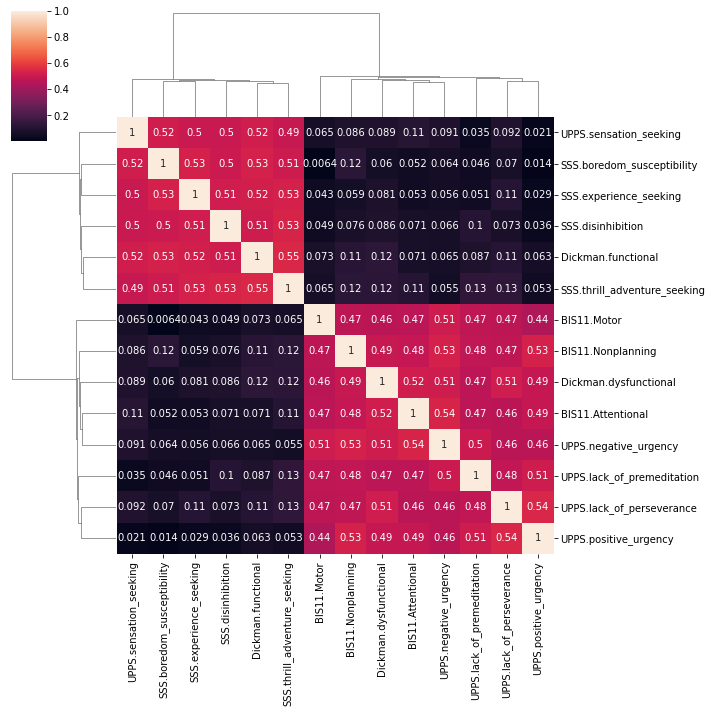

In [15]:
cc = simdata_df[impulsivity_vars].corr()

sns.clustermap(cc, method='average', annot=True)

Fit a logistic regression model to estimate the relationship between the `everArrested` variable and several other variables.

In [16]:
glm_imp_arrest = smf.glm(
    formula='everArrested ~ 1 + impulsivity + senseek + Age + Sex', 
    data=simdata_df,
    family=sm.families.Binomial())
logistic_result = glm_imp_arrest.fit()

print(logistic_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           everArrested   No. Observations:                  500
Model:                            GLM   Df Residuals:                      495
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -170.12
Date:                Tue, 27 Sep 2022   Deviance:                       340.25
Time:                        11:16:31   Pearson chi2:                     450.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2741
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -9.2532      1.158     -7.994      

Now run the analysis 1000 times and compute the proportion of signfiicant results for each variable.  This will take a couple of minutes.


In [17]:
nruns = 1000
results = []
alpha = .05
# true betas for data generation
betas = np.array([0.0, 0.5, 0.2, 0.5])

for _ in range(nruns):
    rundata, _, _ = generate_synthetic_data(arrest_noise_sd=5, betas=betas)
    glm_imp_arrest = smf.glm(
        formula='everArrested ~ 1 + impulsivity + senseek + Age + Sex', 
        data=rundata,
        family=sm.families.Binomial())
    logistic_result = glm_imp_arrest.fit()
    results.append(np.hstack((
        logistic_result.pvalues[1:].values < alpha,
        logistic_result.params[1:])))

results_df = pd.DataFrame(results, columns=['pval_impulsivity', 'pval_senseek', 'pval_Age', 'pval_Sex',
                                            'param_impulsivity', 'param_senseek', 'param_Age', 'param_Sex'])

In [18]:
mean_results = results_df.mean(axis=0)
summary_df = pd.DataFrame({
    'p_significant': mean_results[:4].values, 
    'mean estimated beta': mean_results[4:].values,
    'true beta': betas},
    index=[i.replace('pval_', '') for i in results_df.columns[:4]])
summary_df

,p_significant,mean estimated beta,true beta
impulsivity,0.049,0.001571,0.0
senseek,0.292,0.183175,0.5
Age,0.863,0.070225,0.2
Sex,0.118,0.178988,0.5


In [24]:
# validation tests:

for i in summary_df.index:
    if summary_df.loc[i, 'true beta'] == 0:
        assert np.allclose(summary_df.loc[i, 'p_significant'], alpha, atol=.02), f'{i} should be null'
    else:
        assert summary_df.loc[i, 'p_significant'] > alpha, f'{i} should be non-null'
        

Now that we have confirmed that our model is working correctly, we can apply it to the real data.

In [ ]:
def get_eisenberg_data(repo=None):
    if repo is None:
        repo = 'https://raw.githubusercontent.com/IanEisenberg/Self_Regulation_Ontology/master/Data/Complete_02-16-2019/'
    behavdata = pd.read_csv(repo + 'meaningful_variables.csv', index_col=0)
    demoghealthdata = pd.read_csv(repo + 'demographic_health.csv', index_col=0)
    alldata = demoghealthdata.join(behavdata, how='inner')

    rename_dict = {
        'upps_impulsivity_survey': 'UPPS',
        'sensation_seeking_survey': 'SSS',
        'dickman_survey': 'Dickman', 
        'bis11_survey': 'BIS11'
    }
    impulsivity_vars = []
    for column in alldata.columns:
        for k, v in rename_dict.items():
            if k in column:
                alldata.rename(columns={column: column.replace(k, v)}, inplace=True)
                impulsivity_vars.append(column.replace(k, v))


    impulsivity_data = alldata[['ArrestedChargedLifeCount', 'Age', 'Sex'] + impulsivity_vars]

    impulsivity_data.dropna(inplace=True)
    impulsivity_data.loc[:, 'everArrested'] = (impulsivity_data.ArrestedChargedLifeCount > 0).astype('int')
    fa = FactorAnalyzer(2, rotation='oblimin')
    fa_scores = fa.fit_transform(impulsivity_data[impulsivity_vars])
    # order the factors: impulsivity then sensation seeking

    loadings = pd.DataFrame(
        fa.loadings_,
        columns=['Factor 1', 'Factor 2'],
        index=impulsivity_vars).sort_values(
            by=['Factor 1', 'Factor 2'], ascending=False)
    print('Factor Loadings \n%s' % loadings)
    if loadings.loc['UPPS.sensation_seeking', :].diff()[1] > 0:
        factors = [0, 1]
    else:
        factors = [1, 0]
    impulsivity_data.loc[:, 'impulsivity'] = fa_scores[:, factors[0]]
    impulsivity_data.loc[:, 'senseek'] = fa_scores[:, factors[1]]

    return impulsivity_data[impulsivity_vars + ['Age', 'Sex', 'everArrested', 'impulsivity', 'senseek']], impulsivity_vars


impulsivity_data, impulsivity_vars = get_eisenberg_data()

In [ ]:
cc = impulsivity_data[impulsivity_vars].corr()

sns.clustermap(cc, method='average', annot=True)

Run logistic regression on the real data

In [ ]:
glm_imp_arrest = smf.glm(
    formula='everArrested ~ 1 + impulsivity + senseek + Age + Sex', 
    data=impulsivity_data,
    family=sm.families.Binomial())
logistic_result = glm_imp_arrest.fit()
print(logistic_result.summary())

### Generating simulated data using an existing dataset

In many cases we have an existing dataset, but we would like to develop our analytic tools without exposing ourself to that dataset.  In this case, we use a synthetic data generator to generate datasets with similar features/distributions as the dataset of interest, in order to test our methods without unblinding ourselves to the actual data.

#### Synthetic null data using randomization

A simple approach is to resample the existing datset in a way that ensures the null hypothesis. This is only appropriate if the observations are *exchangeable* - which will generally be true if the observations are independent random samples from a population, as they were in the Eisenberg dataset.  We would not want to use this approach if there was structure in the data -- e.g. if there are multiple observations per individual, or related individuals in the sample.

### Using simulations to identify peeking in machine learning analyses

A common problem with machine learning analyses is the leakage of information from the test set into the training procedure (also known as "peeking").  In some cases this can be identified through the use of simulations.


In [ ]:
# generate data with a true elationship between X and y
def generate_cv_data(nfeatures=1000, nobs=100, n_nonzero_features=10, seed=None, noise_sd=0.5):
    rng = np.random.default_rng(seed)
    X = rng.normal(size=(nobs, nfeatures))
    betas = np.zeros(nfeatures)
    if n_nonzero_features > 0:
        betas[:n_nonzero_features] = 10
    y = ((X.dot(betas) + rng.normal(scale=noise_sd, size=nobs)) > 0).astype('int')
    return(X, y)


X, y = generate_cv_data(n_nonzero_features=10)

Run crossvalidation with feature selection inside the crossvalidation loop, using only the training data:

In [ ]:
def crossvalidate(X, y, seed=None, clf=None, n_splits=25, shuffle_y=False):
    if clf is None:
        clf = LinearSVC()
    rng = np.random.RandomState(seed)

    scores = []
    if shuffle_y:
        y = y.copy()
        np.random.shuffle(y)

    selector = SelectKBest(f_classif, k=10)

    for i in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rng)
        X_train_fsel = selector.fit_transform(X_train, y_train)
        X_test_fsel = selector.transform(X_test)

        clf.fit(X_train_fsel, y_train)
        y_pred = clf.predict(X_test_fsel)
        scores.append(balanced_accuracy_score(y_test, y_pred))
    return(np.mean(np.array(scores)))


crossvalidate(X, y)

If we run the crossvalidation loop while shuffling the y variable, we will see that the accuracy is at 50%, as expected.

In [ ]:
crossvalidate(X, y, shuffle_y=True)

Now let's include a feature selection procedure on the entire dataset, outside of the crossvalidation loop:

In [ ]:


def crossvalidate_with_fsel(X, y, seed=None, clf=None, n_splits=25, shuffle_y=False):
    if clf is None:
        clf = LinearSVC()
    rng = np.random.RandomState(seed)

    scores = []
    if shuffle_y:
        y = y.copy()
        np.random.shuffle(y)

    selector = SelectKBest(f_classif, k=10)
    X_fsel = selector.fit_transform(X, y)

    for i in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X_fsel, y, test_size=0.33, random_state=rng)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        scores.append(balanced_accuracy_score(y_test, y_pred))
    return(np.mean(np.array(scores)))


crossvalidate_with_fsel(X, y)

If we run this same analysis while shuffling the y variables, we will see that the accuracy is well above chance, reflecting double-dipping.

In [ ]:
crossvalidate_with_fsel(X, y, shuffle_y=True)

### Generating matched synthetic data

In some cases we have an existing dataset but we would like to test our analysis code on synthetic versions of the dataset.  A useful tool for this is the Synthetic Data Vault (SDV) package.


In [ ]:
# generate synthetic data matching impulsivity_data

age_positive = Positive(columns='age')

metadata = {
    'constraints': [],
    'fields': {
        'Age': {'type': 'numerical', 'subtype': 'integer'},
        'Sex': {'type': 'categorical'},
        'everArrested': {'type': 'boolean'}}}

for column in impulsivity_data.columns:
    if column not in metadata['fields']:
        metadata['fields'][column] = {'type': 'numerical', 'subtype': 'float'}

In [ ]:
model = TabularPreset(name='FAST_ML', metadata=metadata)

In [ ]:
model.fit(impulsivity_data)

In [ ]:
synthetic_data = model.sample(num_rows=500)

cc = synthetic_data[impulsivity_vars].corr()
sns.clustermap(cc, method='average', annot=True)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
xvar = 'everArrested'

sns.boxplot(data=synthetic_data, x=xvar, y='impulsivity', ax=ax[0])
sns.swarmplot(data=synthetic_data, x=xvar, y='impulsivity', ax=ax[0], color='black', alpha=0.5)

sns.boxplot(data=synthetic_data, x=xvar, y='senseek', ax=ax[1])
sns.swarmplot(data=synthetic_data, x=xvar, y='senseek', ax=ax[1], color='black', alpha=0.5)

In [ ]:
impulsivity_data.loc[:, 'AgeSquared'] = (impulsivity_data.Age - impulsivity_data.Age.mean()) ** 2

glm_imp_arrest = smf.glm(
    formula='everArrested ~ 1 + impulsivity + senseek + Age +   Sex', 
    data=impulsivity_data,
    family=sm.families.Binomial())
logistic_result = glm_imp_arrest.fit()

print(logistic_result.summary())

In [ ]:

glm_imp_arrest = smf.glm(
    formula='everArrested ~ 1 + impulsivity + senseek + Age +   Sex', 
    data=synthetic_data,
    family=sm.families.Binomial())
logistic_result = glm_imp_arrest.fit()

print(logistic_result.summary())

### Generating synthetic neuroimaging data

It can be useful to benchmark analyses using synthetic data before ever applying them to real data.  In the best case, one would actually pre-register the analyses developed on synthetic data prior applying them to real data.

Let's say that we wanted to test a new "biomarker" for brain age using task fMRI.  We could start by generating some random data (using the MNI305 mask as our starting point) and then apply our new technique to that, either using a completely random value for age, or creating age to have a specific relationship to the synthetic brain data.

First, we can set up a NiftiMasker based on the MNI305 mask:

In [39]:
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template

mnimask = load_mni152_brain_mask(resolution=3.)
mnitemplate = load_mni152_template(resolution=3.)

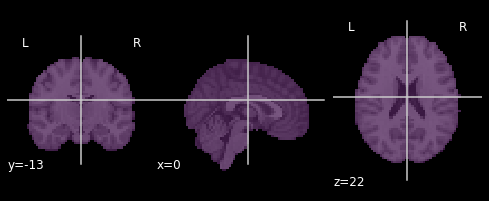

In [40]:
import nilearn.plotting

display = nilearn.plotting.plot_anat(mnitemplate)
display.add_overlay(mnimask, alpha=0.5)

In [41]:
masker = NiftiMasker()
maskdata = masker.fit_transform(mnimask)
maskdata.shape


(1, 69765)

We then generate random Gaussian data for each subject (let's say 100 subjects).


In [110]:
rng = np.random.default_rng(12345)
nsubs = 100
syndata = rng.normal(size=(nsubs, maskdata.shape[1]))

In [111]:
synimg = smooth_img(masker.inverse_transform(syndata), 8)
synimg.shape

(67, 79, 64, 100)

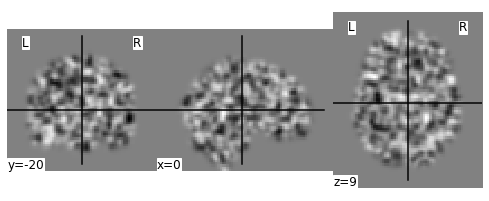

In [112]:
nilearn.plotting.plot_img(index_img(synimg, 1), cmap='gray')

### Testing our biomarker

Now let's test our biomarker.  Our innovation is to implement a feature selection procedure called Recursive Feature Elimination (RFE) to reduce the dimensionality of the data for the prediction model.  

In [113]:

def train_brainage_model(img, y, mask, nfeatures=50, n_splits=20, 
                         seed=None, shuffle_y=False, fsel='outside'):
    assert fsel is None or fsel in ('inside', 'outside')
    assert y.shape[0] == img.shape[-1]
    masker = NiftiMasker(mask)
    maskdata = masker.fit_transform(img)
    
    rng = np.random.RandomState(seed)
    if shuffle_y:
        y = y.copy()
        np.random.shuffle(y)

    estimator = LinearSVR()
    if fsel == 'outside':
        #  perform recursive feature elimination outside of CV
        selector = SelectKBest(f_regression, k=nfeatures)
        X = selector.fit_transform(maskdata, y)
    else:
        X = maskdata

    scores = []

    clf = LinearSVR()

    for i in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rng)
        if fsel == 'inside':
            # perform RFE inside CV loop
            selector = SelectKBest(f_regression, k=nfeatures)
            X_train = selector.fit_transform(X_train, y_train)
            X_test = selector.transform(X_test)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        scores.append(r2_score(y_test, y_pred))
    return np.mean(scores)
    

age = rng.normal(loc=40, scale=10, size=nsubs)

train_brainage_model(synimg, age, mnimask)


0.2226367802373761

If we didn't know that there was no true relationship between the brain data and age, we wouldn't realize that this was weird.  We would likely want to know whether the observed $R^2$ is sufficiently larger than what one would expect under the null hypothesis of no predictive relationship (i.e. $R^2 = 0$).  To determine this, we can run the model repeatedly while shuffling the order of the y variable, which essentially breaks the relationship on average between the X and y variables.  In principle this should have a mean of zero (or less, given that crossvalidation using regression with smallish samples can often lead to negative $R^2$ values when the model fits the data worse than the mean; see [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7250718/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7250718/) for more).

0.23610568175297109


(array([ 1.,  2.,  7.,  2.,  8.,  7.,  8., 10.,  4.,  1.]),
 array([0.0692953 , 0.10004723, 0.13079915, 0.16155108, 0.19230301,
        0.22305493, 0.25380686, 0.28455879, 0.31531072, 0.34606264,
        0.37681457]),
 <BarContainer object of 10 artists>)

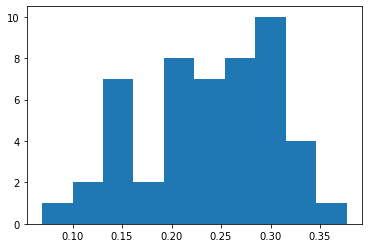

In [114]:
scores = []
nsimruns = 50
for i in range(nsimruns):
    scores.append(train_brainage_model(synimg, age, mnimask, shuffle_y=True))
print(np.mean(scores))
plt.hist(scores)

Wait, what?  The $R^2$ scores are all well above zero even when we shuffle the data, which means that there must be some kind of leaking of information from the test data into the training. In this case, it's due to the fact that our feature selection procedure was applied on the entire dataset prior to crossvalidation, rather than within the crossvalidation folks. If we move the feature selection step inside the crossvalidation loop, we should see that the predictive accuracy decreases.

In [115]:
train_brainage_model(synimg, age, mnimask, fsel='inside')


-0.3201515497947321

This example shows how injecting synthetic data into our analysis procedures can help ensure that they are not providing us with biased results.